# **Load Data**

In [ ]:
import pandas as pd
data = pd.read_csv('mmm.csv',parse_dates=['Date'],index_col='Date')
data.head()

,TV,Radio,Banners,Sales
Date,,,,
2018-01-07,13528.1,0.00,0.00,9779.80
2018-01-14,0.0,5349.65,2218.93,13245.19
2018-01-21,0.0,4235.86,2046.96,12022.66
2018-01-28,0.0,3562.21,0.00,8846.95
2018-02-04,0.0,0.00,2187.29,9797.07


In [ ]:
data.shape

(200, 4)

# **Saturation Effect**

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_is_fitted, check_array

class ExponentialSaturation(BaseEstimator, TransformerMixin):
    def __init__(self, a=1.):
        self.a = a

    def fit(self, X, y=None):
        X = check_array(X)
        self._check_n_features(X, reset=True) # from BaseEstimator
        return self

    def transform(self, X):
        check_is_fitted(self)
        X = check_array(X)
        self._check_n_features(X, reset=False) # from BaseEstimator
        return 1 - np.exp(-self.a*X)

# **Carryover Effect**

In [ ]:
from scipy.signal import convolve2d
import numpy as np

class ExponentialCarryover(BaseEstimator, TransformerMixin):
    def __init__(self, strength=0.5, length=1):
        self.strength = strength
        self.length = length

    def fit(self, X, y=None):
        X = check_array(X)
        self._check_n_features(X, reset=True)
        self.sliding_window_ = (
            self.strength ** np.arange(self.length + 1)
        ).reshape(-1, 1)
        return self

    def transform(self, X: np.ndarray):
        check_is_fitted(self)
        X = check_array(X)
        self._check_n_features(X, reset=False)
        convolution = convolve2d(X, self.sliding_window_)
        if self.length > 0:
            convolution = convolution[: -self.length]
        return convolution

# **Column Transformer & Pipeline**

In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression

adstock = ColumnTransformer(
    [
     ('tv_pipe', Pipeline([
                           ('carryover', ExponentialCarryover()),
                           ('saturation', ExponentialSaturation())
     ]), ['TV']),
     ('radio_pipe', Pipeline([
                           ('carryover', ExponentialCarryover()),
                           ('saturation', ExponentialSaturation())
     ]), ['Radio']),
     ('banners_pipe', Pipeline([
                           ('carryover', ExponentialCarryover()),
                           ('saturation', ExponentialSaturation())
     ]), ['Banners']),
    ],
    remainder='passthrough'
)

model = Pipeline([
                  ('adstock', adstock),
                  ('regression', LinearRegression())
])

# **Model Performance (Before Tuning)**



In [ ]:
from sklearn.model_selection import cross_val_score, TimeSeriesSplit

X = data.drop(columns=['Sales'])
y = data['Sales']

model.fit(X, y)
print(cross_val_score(model, X, y, cv=TimeSeriesSplit()).mean())

0.5527190073236669


# **Hyperparamter Tuning**

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint

tuned_model = RandomizedSearchCV(
    estimator=model,
    param_distributions={
        'adstock__tv_pipe__carryover__strength': uniform(0, 1),
        'adstock__tv_pipe__carryover__length': randint(0, 6),
        'adstock__tv_pipe__saturation__a': uniform(0, 0.01),
        'adstock__radio_pipe__carryover__strength': uniform(0, 1),
        'adstock__radio_pipe__carryover__length': randint(0, 6),
        'adstock__radio_pipe__saturation__a': uniform(0, 0.01),
        'adstock__banners_pipe__carryover__strength': uniform(0, 1),
        'adstock__banners_pipe__carryover__length': randint(0, 6),
        'adstock__banners_pipe__saturation__a': uniform(0, 0.01),
    },
    n_iter=1000,
    cv=TimeSeriesSplit(),
    random_state=0
)

# **Model Performance (After Tuning)**

In [ ]:
tuned_model.fit(X, y)
print(cross_val_score(tuned_model, X, y, cv=TimeSeriesSplit()).mean())

0.897648854921292


In [ ]:
tuned_model.best_params_

{'adstock__banners_pipe__carryover__length': 0,
 'adstock__banners_pipe__carryover__strength': 0.8751433768323792,
 'adstock__banners_pipe__saturation__a': 0.0065945872672305865,
 'adstock__radio_pipe__carryover__length': 0,
 'adstock__radio_pipe__carryover__strength': 0.47826450020005506,
 'adstock__radio_pipe__saturation__a': 0.005530533233767334,
 'adstock__tv_pipe__carryover__length': 4,
 'adstock__tv_pipe__carryover__strength': 0.4465948502605501,
 'adstock__tv_pipe__saturation__a': 5.4866952650955984e-05}

In [ ]:
print(tuned_model.best_estimator_.named_steps['regression'].coef_)
print(tuned_model.best_estimator_.named_steps['regression'].intercept_)

[10225.65124621  2402.6630737   2453.7368643 ]
5457.3358032505375


# **Model Prediction Test**

In [ ]:
X_new = pd.DataFrame({
    'TV': [10000, 0, 0],
    'Radio': [0, 3000, 0],
    'Banners': [1000, 1000, 1000]
})

tuned_model.predict(X_new)

array([12225.82566253, 12532.63109588,  8967.66170481])

In [ ]:
X_new

,TV,Radio,Banners
0,10000,0,1000
1,0,3000,1000
2,0,0,1000


# **Saturated Spend vs Predicted Sales**



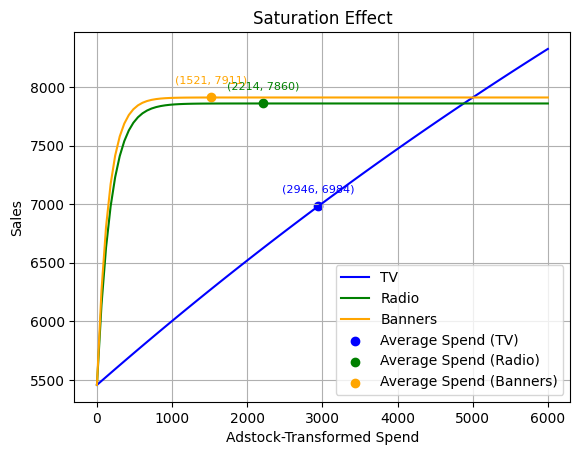

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Use the coefficients and intercept you provided
coefficients = {
    'TV': 10225.65124621,
    'Radio': 2402.6630737,
    'Banners': 2453.7368643
}
intercept = 5457.3358032505375

spend_range = np.linspace(0, 6000, 100)

# TV adstock-transformed spend values
adstock_values_tv = 1 - np.exp(-5.4866952650955984e-05 * spend_range)
# TV predicted sales
predicted_sales_tv = intercept + coefficients['TV'] * adstock_values_tv

# Radio adstock-transformed spend values
adstock_values_radio = 1 - np.exp(-0.005530533233767334 * spend_range)
# Radio predicted sales
predicted_sales_radio = intercept + coefficients['Radio'] * adstock_values_radio

# Banners adstock-transformed spend values
adstock_values_banners = 1 - np.exp(-0.0065945872672305865 * spend_range)
# Banners predicted sales
predicted_sales_banners = intercept + coefficients['Banners'] * adstock_values_banners

average_spend_tv = data['TV'].mean()
average_spend_radio = data['Radio'].mean()
average_spend_banners = data['Banners'].mean()

plt.plot(spend_range, predicted_sales_tv, label='TV', color='blue')
plt.plot(spend_range, predicted_sales_radio, label='Radio', color='green')
plt.plot(spend_range, predicted_sales_banners, label='Banners', color='orange')

plt.scatter(average_spend_tv, intercept + coefficients['TV'] * (1 - np.exp(-5.4866952650955984e-05 * average_spend_tv)), color='blue', marker='o', label='Average Spend (TV)')
plt.scatter(average_spend_radio, intercept + coefficients['Radio'] * (1 - np.exp(-0.005530533233767334 * average_spend_radio)), color='green', marker='o', label='Average Spend (Radio)')
plt.scatter(average_spend_banners, intercept + coefficients['Banners'] * (1 - np.exp(-0.0065945872672305865 * average_spend_banners)), color='orange', marker='o', label='Average Spend (Banners)')

plt.annotate(f"({average_spend_tv:.0f}, {intercept + coefficients['TV'] * (1 - np.exp(-5.4866952650955984e-05 * average_spend_tv)):.0f})",
             (average_spend_tv, intercept + coefficients['TV'] * (1 - np.exp(-5.4866952650955984e-05 * average_spend_tv))),
             textcoords="offset points", xytext=(0,10), ha='center', fontsize=8, color='blue')

plt.annotate(f"({average_spend_radio:.0f}, {intercept + coefficients['Radio'] * (1 - np.exp(-0.005530533233767334 * average_spend_radio)):.0f})",
             (average_spend_radio, intercept + coefficients['Radio'] * (1 - np.exp(-0.005530533233767334 * average_spend_radio))),
             textcoords="offset points", xytext=(0,10), ha='center', fontsize=8, color='green')

plt.annotate(f"({average_spend_banners:.0f}, {intercept + coefficients['Banners'] * (1 - np.exp(-0.0065945872672305865 * average_spend_banners)):.0f})",
             (average_spend_banners, intercept + coefficients['Banners'] * (1 - np.exp(-0.0065945872672305865 * average_spend_banners))),
             textcoords="offset points", xytext=(0,10), ha='center', fontsize=8, color='orange')

plt.xlabel('Adstock-Transformed Spend')
plt.ylabel('Sales')
plt.title('Saturation Effect')
plt.legend()
plt.grid(True)
plt.show()

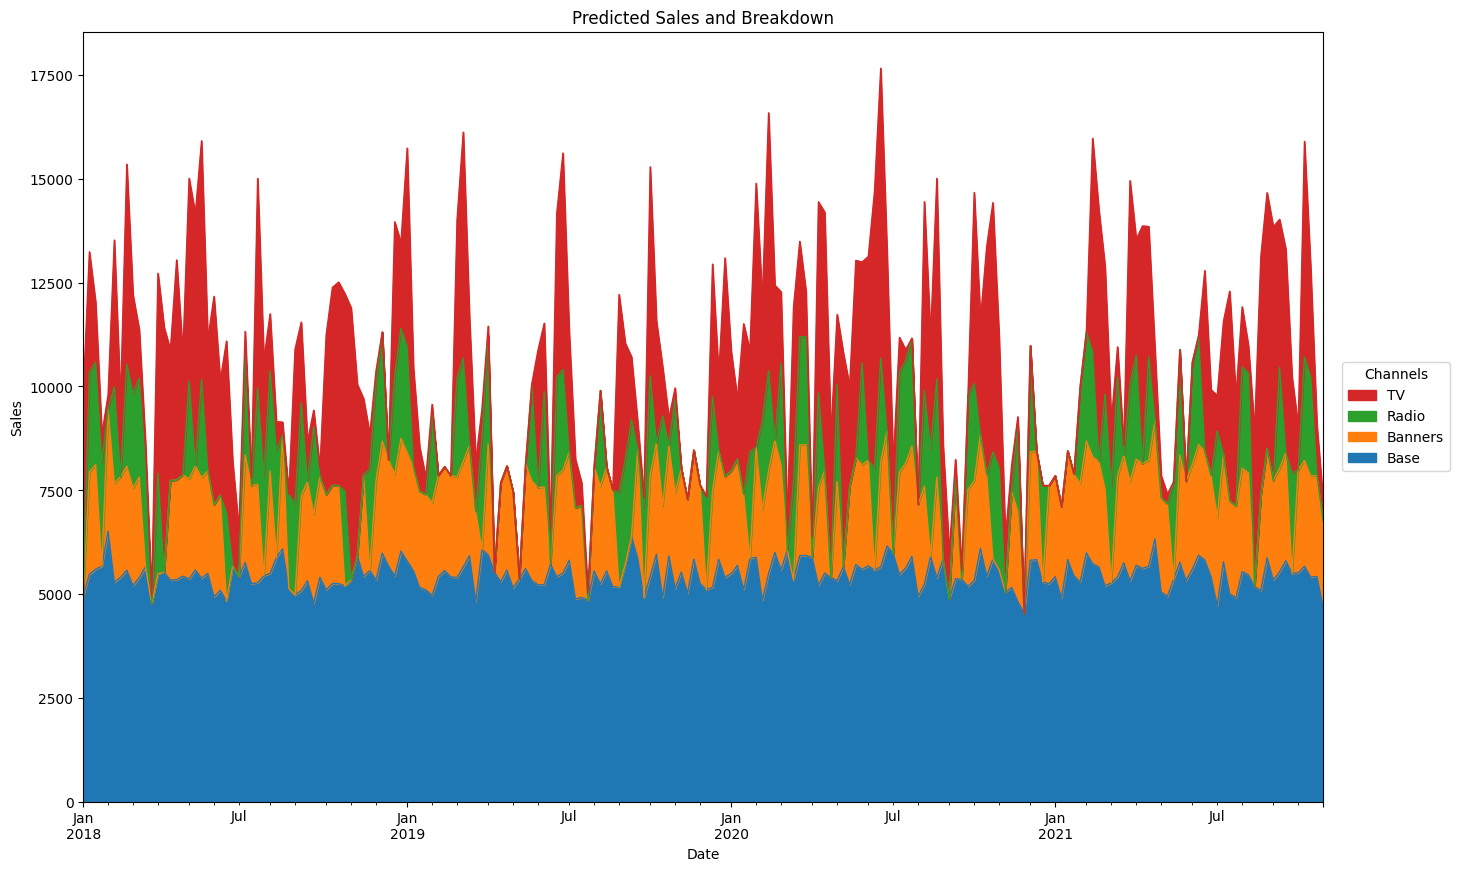

In [ ]:
adstock_data = pd.DataFrame(
    tuned_model.best_estimator_.named_steps['adstock'].transform(X),
    columns=X.columns,
    index=X.index
)

weights = pd.Series(
    tuned_model.best_estimator_.named_steps['regression'].coef_,
    index=X.columns
)

base = tuned_model.best_estimator_.named_steps['regression'].intercept_

unadj_contributions = adstock_data.mul(weights).assign(Base=base)
adj_contributions = (unadj_contributions
                     .div(unadj_contributions.sum(axis=1), axis=0)
                     .mul(y, axis=0)
                    )

ax = (adj_contributions[['Base', 'Banners', 'Radio', 'TV']]
      .plot.area(
          figsize=(16, 10),
          linewidth=1,
          title='Predicted Sales and Breakdown',
          ylabel='Sales',
          xlabel='Date'
      )
     )

handles, labels = ax.get_legend_handles_labels()
ax.legend(
    handles[::-1], labels[::-1],
    title='Channels', loc="center left",
    bbox_to_anchor=(1.01, 0.5)
)